In [39]:
#
# This is an example from jbr Reactor Design Book
# https://github.com/rawlings-group/paresto/blob/master/examples/green_book/bvsm_red.m
# 
# The simulation is done here with scipy
#

Reduced order model with states $V, \epsilon_2$:
$$\frac{dV}{dt} = Q^{in}_B(t)$$
$$\frac{d\epsilon_2}{dt} = \frac{Q^{in}_B(t)c_{Bf}(n^{added}_B-2\epsilon_2)}{(n^{added}_B-2\epsilon_2) + k(n_{A0} - n^{added}_B + \epsilon_2)} $$ 

Calculation of $n_B^{added}$:
$$ n_B^{added} = (V - V(0))c_{Bf} $$

Parameters:
$k = 2.48, \;\;n_{A0} = 2.35$

Initial conditions:
$V = 2370, \;\;\epsilon_2 = 0$

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

In [41]:
# Import data set with flow of B over time
filename = '/home/paperspace/learn_kipet/kipet_paresto/data_sets/flow.dat'
flow_df = pd.read_csv(filename, delimiter=r"\s+", header = None)
flow_df.columns = ['time', 'Qf', 'x']
flow_df['qin_B'] = flow_df['Qf'] / 0.728
flow_df = flow_df.set_index('time')
qinB_traj = flow_df[['qin_B']]
qinB_traj

,qin_B
time,
9.0,0.134365
19.0,1.772804
29.0,1.734587
39.0,1.703319
49.0,1.669967
...,...
829.0,0.000990
839.0,0.000782
849.0,0.000643


In [42]:
# insert first row for time 0
qinB_row0 = pd.DataFrame({'time':[0], 'qin_B':[0]}).set_index('time')
qinB_traj = qinB_traj.append(qinB_row0).sort_index()
qinB_traj.head()

,qin_B
time,
0.0,0.000000
9.0,0.134365
19.0,1.772804
29.0,1.734587
39.0,1.703319


In [43]:
# interpolation of qin_B to use in scipy
qin_B_f = interp1d(qinB_traj.index, qinB_traj['qin_B'], fill_value = 'extrapolate')

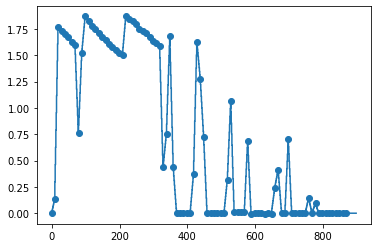

In [44]:
tlist = np.arange(0, 900, 1)
qin_B_list = qin_B_f(tlist)

# check interpolation with original data
fig, ax = plt.subplots()
ax.step(tlist, qin_B_list)
ax.scatter(qinB_traj.index, qinB_traj['qin_B'])

In [45]:
# import lc data
filename = '/home/paperspace/learn_kipet/kipet_paresto/data_sets/lc.dat'
lc_data = pd.read_csv(filename, delimiter=r"\s+", header = None)
lc_data.columns = ['time', 'y']
lc_data = lc_data.set_index('time')

In [46]:
lc_data.head()

,y
time,
414,0.1705
424,0.1604
434,0.1325
444,0.1084
493,0.1014


In [47]:
# function that computes rate for use in scipy solve_ivp
def ratefn(t, y, qin_B_f):
    V = y[0]
    eps2 = y[1]
    
    qin_B = qin_B_f(t)
    cbf = 0.00721
    V0 = 2370
    k = 2.48
    na0 = 2.35
    
    nBadded = (V - V0) * cbf
    
    dV = qin_B
    deps2 = qin_B * cbf * (nBadded - 2 * eps2) / ((nBadded - 2 * eps2) + k*(na0 - nBadded + eps2))
    
    return [dV, deps2]

In [48]:
ratefn_l = lambda t, y: ratefn(t, y, qin_B_f)
sol = solve_ivp(ratefn_l, [0, 900], [2370.0, 0.0])

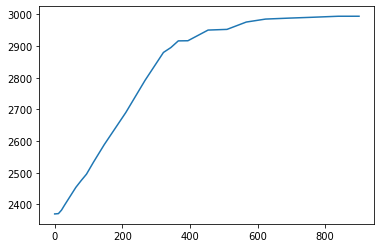

In [49]:
# Volume V vs t
fig, ax = plt.subplots()
ax.plot(sol.t, sol.y[0,:])

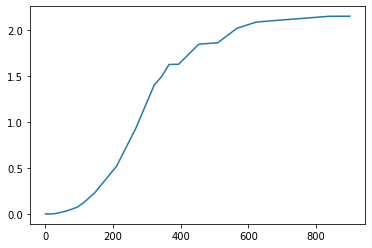

In [50]:
# extent of rxn 2 eps2 vs t
fig, ax = plt.subplots()
ax.plot(sol.t, sol.y[1,:])

In [51]:
# calculate y = nC/(nC + 2*nD)

V0 = 2370
cbf = 0.00721

V = sol.y[0,:]
eps2 = sol.y[1,:]

nBadded = (V - V0) * cbf
nD = eps2
nC = nBadded - 2 * nD

y = nC/(nC + 2*nD + 1e-10)

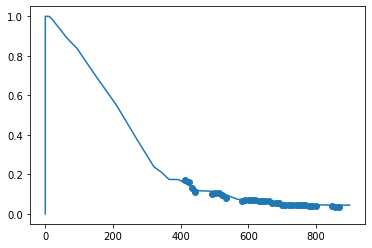

In [52]:
# overlay simulated value with lc data
fig, ax = plt.subplots()
ax.plot(sol.t, y)
ax.scatter(lc_data.index, lc_data['y'])

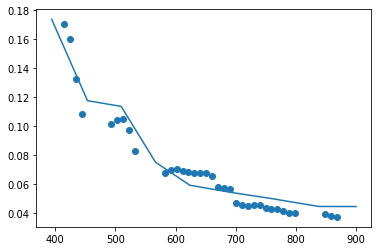

In [53]:
fig, ax = plt.subplots()
ax.plot(sol.t[sol.t >= 380], y[sol.t >= 380])
ax.scatter(lc_data.index, lc_data['y'])